# References

In [2]:
# References

# week11 - Demo_async (functional vs sequential API)
# week07 - Decision trees and ensemble learning (boosting, stacking, bagging)
# week05 - imbalanced_data (standardization)

# Import packages and data

In [85]:
# Standard
import pandas as pd
import numpy as np
import random
import os
import math

# TF and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import metrics
from keras import losses

# Plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
pd.set_option('display.max_columns', None)

# Silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

## Local Data Import

In [122]:
X_train = pd.read_csv('data/X_train.csv')
Y_train = pd.read_csv('data/Y_train.csv')
X_val = pd.read_csv('data/X_val.csv')
Y_val = pd.read_csv('data/Y_val.csv')
X_test = pd.read_csv('data/X_test.csv')
Y_test = pd.read_csv('data/Y_test.csv')

In [123]:
# Two test teams for testing & visualizatons
df_brighton_x = pd.read_csv('data/df_brighton.csv')
df_man_city_x = pd.read_csv('data/df_man_city.csv')

In [124]:
# Two test teams for testing & visualizatons
df_brighton_y = df_brighton_x['total_points']
df_man_city_y = df_man_city_x['total_points']
df_brighton_x.drop(['total_points'], axis=1, inplace=True)
df_man_city_x.drop(['total_points'], axis=1, inplace=True)
df_brighton_y.drop(columns=['Unnamed: 0'], inplace=True)
df_brighton_x.drop(columns=['Unnamed: 0'], inplace=True)
df_man_city_x.drop(columns=['Unnamed: 0'], inplace=True)
df_man_city_y.drop(columns=['Unnamed: 0'], inplace=True)

In [125]:
# Drop unnamed column from all datasets
X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0'], inplace=True)
Y_test.drop(columns=['Unnamed: 0'], inplace=True)

# EDA For Tree Based Algorithms

In [126]:
# Joining in Team Difficulty Index to refactor the player team name
# Importing difficulty data
difficulty_data = pd.read_csv('data/team_difficulty_ind.csv')

# Merging in the difficulty data on home team name (due to limitations on home teams by season [i.e. some home teams in val do not exist in train due to prommotion/relegation])
X_train = X_train.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])
X_val = X_val.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])
X_test = X_test.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])

# Renaming the home difficulty column
X_train.rename(columns={"FDI": "player_team_ind"}, inplace=True)
X_val.rename(columns={"FDI": "player_team_ind"}, inplace=True)
X_test.rename(columns={"FDI": "player_team_ind"}, inplace=True)

In [127]:
# Merging in the difficulty data for the two test teams
df_brighton_x = df_brighton_x.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])
df_man_city_x = df_man_city_x.merge(difficulty_data, how='left', left_on='player_team_name', right_on='team_name').drop(columns = ['team_name'])
df_brighton_x.rename(columns={"FDI": "player_team_ind"}, inplace=True)
df_man_city_x.rename(columns={"FDI": "player_team_ind"}, inplace=True)

In [128]:
# View the data
X_train.head()

,season,player_team_name,opp_team_name,opp_diff_ind,position,GW,was_home,assists_lag_1,bonus_lag_1,bps_lag_1,clean_sheets_lag_1,creativity_lag_1,goals_conceded_lag_1,goals_scored_lag_1,ict_index_lag_1,influence_lag_1,minutes_lag_1,own_goals_lag_1,penalties_missed_lag_1,penalties_saved_lag_1,red_cards_lag_1,saves_lag_1,selected_lag_1,player_team_score_lag_1,opp_team_score_lag_1,threat_lag_1,total_points_lag_1,value_lag_1,yellow_cards_lag_1,assists_lag_3,bonus_lag_3,bps_lag_3,clean_sheets_lag_3,creativity_lag_3,goals_conceded_lag_3,goals_scored_lag_3,ict_index_lag_3,influence_lag_3,minutes_lag_3,own_goals_lag_3,penalties_missed_lag_3,penalties_saved_lag_3,red_cards_lag_3,saves_lag_3,selected_lag_3,player_team_score_lag_3,opp_team_score_lag_3,threat_lag_3,total_points_lag_3,value_lag_3,yellow_cards_lag_3,assists_lag_5,bonus_lag_5,bps_lag_5,clean_sheets_lag_5,creativity_lag_5,goals_conceded_lag_5,goals_scored_lag_5,ict_index_lag_5,influence_lag_5,minutes_lag_5,own_goals_lag_5,penalties_missed_lag_5,penalties_saved_lag_5,red_cards_lag_5,saves_lag_5,selected_lag_5,player_team_score_lag_5,opp_team_score_lag_5,threat_lag_5,total_points_lag_5,value_lag_5,yellow_cards_lag_5,player_team_ind
0,2018-19,West Ham,Liverpool,4,DEF,1,False,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.406561,-1.049287,-1.053934,-0.391042,-0.532634,-3.367246,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.408072,-1.599196,-1.619560,-0.494354,-0.694657,-3.370340,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-0.907968,-0.079379,-0.061733,-0.048352,-0.093734,-0.177503,-0.409936,-1.808301,-1.899736,-0.529878,-0.752585,-3.373454,-0.430582,2
1,2018-19,West Ham,Bournemouth,1,DEF,2,True,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.158255,-1.049287,2.131566,-0.391042,-0.532634,0.335223,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.156925,-1.599196,3.264136,-0.494354,-0.694657,0.332269,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-0.907968,-0.079379,-0.061733,-0.048352,-0.093734,-0.177503,-0.155985,-1.808301,3.816565,-0.529878,-0.752585,0.329490,-0.430582,2
2,2018-19,West Ham,Arsenal,4,DEF,3,False,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.187225,-0.249288,0.538816,-0.391042,-0.532634,0.335223,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.171575,-0.990640,2.043212,-0.494354,-0.694657,0.332269,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-0.907968,-0.079379,-0.061733,-0.048352,-0.093734,-0.177503,-0.170799,-1.121215,2.387490,-0.529878,-0.752585,0.329490,-0.430582,2
3,2018-19,West Ham,Wolves,2,DEF,4,True,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.240123,-0.249288,1.335191,-0.391042,-0.532634,0.267905,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.194293,-0.787788,2.043212,-0.494354,-0.694657,0.309829,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-0.907968,-0.079379,-0.061733,-0.048352,-0.093734,-0.177503,-0.193770,-0.892187,2.387490,-0.529878,-0.752585,0.307048,-0.430582,2
4,2018-1

In [129]:
# Capture categorical variables
cat_columns = ['GW', 'player_team_ind', 'opp_diff_ind','position', 'was_home']

#dropping season, player_team_name, opp_team_name due to categorical encoding limitations (e.g. Season 2018/19 does not exist in Validation set)
dropped_columns = ['season', 'player_team_name', 'opp_team_name']

# Create dummy variables for all other categorical variables
X_train_encoded = pd.get_dummies(X_train, columns = cat_columns)
X_train_encoded.drop(columns=dropped_columns, inplace=True)

X_val_encoded = pd.get_dummies(X_val, columns = cat_columns)
X_val_encoded.drop(columns=dropped_columns, inplace=True)

X_test_encoded = pd.get_dummies(X_test, columns = cat_columns)
X_test_encoded.drop(columns=dropped_columns, inplace=True)

In [130]:
# Encode the two test teams
cat_columns_test = ['GW', 'player_team_ind', 'opp_diff_ind','position', 'was_home']

#dropping season, player_name, player_team_name, opp_team_name due to categorical encoding limitations (e.g. Season 2018/19 does not exist in Validation set)
dropped_columns_test = ['player_name','season', 'player_team_name', 'opp_team_name']

# Create dummy variables for all other categorical variables
df_brighton_x_encoded = pd.get_dummies(df_brighton_x, columns = cat_columns_test)
df_brighton_x_encoded.drop(columns=dropped_columns_test, inplace=True)

df_man_city_x_encoded = pd.get_dummies(df_man_city_x, columns = cat_columns_test)
df_man_city_x_encoded.drop(columns=dropped_columns_test, inplace=True)

In [131]:
# Add a false GW7 due to her majesty's passing
X_test_encoded['GW_7'] = False
X_test_encoded = X_test_encoded[X_train_encoded.columns]

In [132]:
for i in X_test_encoded.columns:
    if i not in df_man_city_x_encoded.columns:
        df_man_city_x_encoded[i] = False
    if i not in df_brighton_x_encoded.columns:
        df_brighton_x_encoded[i] = False
df_man_city_x_encoded = df_man_city_x_encoded[X_train_encoded.columns]
df_brighton_x_encoded = df_brighton_x_encoded[X_train_encoded.columns]

In [133]:
X_train_encoded

,assists_lag_1,bonus_lag_1,bps_lag_1,clean_sheets_lag_1,creativity_lag_1,goals_conceded_lag_1,goals_scored_lag_1,ict_index_lag_1,influence_lag_1,minutes_lag_1,own_goals_lag_1,penalties_missed_lag_1,penalties_saved_lag_1,red_cards_lag_1,saves_lag_1,selected_lag_1,player_team_score_lag_1,opp_team_score_lag_1,threat_lag_1,total_points_lag_1,value_lag_1,yellow_cards_lag_1,assists_lag_3,bonus_lag_3,bps_lag_3,clean_sheets_lag_3,creativity_lag_3,goals_conceded_lag_3,goals_scored_lag_3,ict_index_lag_3,influence_lag_3,minutes_lag_3,own_goals_lag_3,penalties_missed_lag_3,penalties_saved_lag_3,red_cards_lag_3,saves_lag_3,selected_lag_3,player_team_score_lag_3,opp_team_score_lag_3,threat_lag_3,total_points_lag_3,value_lag_3,yellow_cards_lag_3,assists_lag_5,bonus_lag_5,bps_lag_5,clean_sheets_lag_5,creativity_lag_5,goals_conceded_lag_5,goals_scored_lag_5,ict_index_lag_5,influence_lag_5,minutes_lag_5,own_goals_lag_5,penalties_missed_lag_5,penalties_saved_lag_5,red_cards_lag_5,saves_lag_5,selected_lag_5,player_team_score_lag_5,opp_team_score_lag_5,threat_lag_5,total_points_lag_5,value_lag_5,yellow_cards_lag_5,GW_1,GW_2,GW_3,GW_4,GW_5,GW_6,GW_7,GW_8,GW_9,GW_10,GW_11,GW_12,GW_13,GW_14,GW_15,GW_16,GW_17,GW_18,GW_19,GW_20,GW_21,GW_22,GW_23,GW_24,GW_25,GW_26,GW_27,GW_28,GW_29,GW_30,GW_31,GW_32,GW_33,GW_34,GW_35,GW_36,GW_37,GW_38,player_team_ind_1,player_team_ind_2,player_team_ind_3,player_team_ind_4,opp_diff_ind_1,opp_diff_ind_2,opp_diff_ind_3,opp_diff_ind_4,position_DEF,position_FWD,position_GK,position_MID,was_home_False,was_home_True
0,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.406561,-1.049287,-1.053934,-0.391042,-0.532634,-3.367246,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.408072,-1.599196,-1.619560,-0.494354,-0.694657,-3.370340,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-0.907968,-0.079379,-0.061733,-0.048352,-0.093734,-0.177503,-0.409936,-1.808301,-1.899736,-0.529878,-0.752585,-3.373454,-0.430582,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,True,False
1,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.158255,-1.049287,2.131566,-0.391042,-0.532634,0.335223,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.156925,-1.599196,3.264136,-0.494354,-0.694657,0.332269,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-0.907968,-0.079379,-0.061733,-0.048352,-0.093734,-0.177503,-0.155985,-1.808301,3.816565,-0.529878,-0.752585,0.329490,-0.430582,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True
2,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,-0.038724,-0.029791,-0.025034,-0.044671,-0.150989,-0.187225,-0.249288,0.538816,-0.391042,-0.532634,0.335223,-0.231739,-0.286585,-0.332783,-0.750849,-0.495921,-0.548162,-0.684023,-0.279485,-0.684830,-0.704265,-0.872107,-0.063972,-0.049956,-0.04048,-0.075565,-0.171572,-0.171575,-0.990640,2.043212,-0.494354,-0.694657,0.332269,-0.364314,-0.333476,-0.387287,-0.800614,-0.566673,-0.586000,-0.754589,-0.316723,-0.727066,-0.756172,-

# Tree Algorithm Function Configuration
- Decision Tree Regression
- Gradient Boosting Regression
- Random Forest Boosting Regression
- XGBoosted Regression

In [38]:
# Create decision tree function
def decision_tree(X_train, Y_train, X_val, Y_val, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # Decision Tree
    # Instantiate model
    dt = DecisionTreeRegressor(criterion='squared_error',random_state=0, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    dt.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = dt.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)

    # Calculate MAE
    val_mae = mean_absolute_error(Y_val, Y_val_pred)

    # Print results
    print('Decision Tree')
    print('Validation MSE: %.3f' % val_mse)
    print('Validation MAE: %.3f' % val_mae)

In [25]:
# Create gradient boosting function
def gradient_boosted_regression(X_train, Y_train, X_val, Y_val, n_estimators = 100, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # Gradient Boosted Regression
    # Instantiate model
    gbr = GradientBoostingRegressor(criterion='squared_error', random_state=0, n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    gbr.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = gbr.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)

    # Calculate MAE
    val_mae = mean_absolute_error(Y_val, Y_val_pred)

    # Print results
    print('Gradient Boosted Regression')
    print('Validation MSE: %.3f' % val_mse)
    print('Validation MAE: %.3f' % val_mae)


In [20]:
# Create random forest function
def random_forest(X_train, Y_train, X_val, Y_val, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # Random Forest
    # Instantiate model
    rf = RandomForestRegressor(criterion='squared_error',random_state=0, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    rf.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = rf.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)

    # Calculate MAE
    val_mae = mean_absolute_error(Y_val, Y_val_pred)

    # Print results
    print('Random Forest')
    print('Validation MSE: %.3f' % val_mse)
    print('Validation MAE: %.3f' % val_mae)
    
    # Return validation MSE
    return val_mse

In [23]:
# Create XGBoost function
def extreme_gradient_boosting(X_train, Y_train, X_val, Y_val, n_estimators = 100, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # XGBoost
    # Instantiate model
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=0, n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    xgb_model.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = xgb_model.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)

    # Calculate MAE
    val_mae = mean_absolute_error(Y_val, Y_val_pred)

    # Print results
    print('XGBoost')
    print('Validation MSE: %.3f' % val_mse)
    print('Validation MAE: %.3f' % val_mae)
    
    # Return validation MSE
    return val_mse

# Generate Baselines

In [ ]:
# Decision Tree Regression - baseline - no hyperparameter tuning
decision_tree(X_train_encoded, Y_train, X_val_encoded, Y_val)

In [ ]:
# Gradient Boosted Regression - baseline - no hyperparameter tuning
gradient_boosted_regression(X_train_encoded, Y_train, X_val_encoded, Y_val)

In [ ]:
# Random Forest Regression - baseline - no hyperparameter tuning
random_forest(X_train_encoded, Y_train, X_val_encoded, Y_val)

In [ ]:
# XGBoost Regression - baseline - no hyperparameter tuning
extreme_gradient_boosting(X_train_encoded, Y_train, X_val_encoded, Y_val)

# Configure Hyperparameter Tuning

In [49]:
# Reconfigure functions for hyperparameter tuning

# Create decision tree function for hyperparameter tuning
def decision_tree_hp(X_train, Y_train, X_val, Y_val, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # Decision Tree
    # Instantiate model
    dt = DecisionTreeRegressor(criterion='squared_error',random_state=0, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    dt.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = dt.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)

    return val_mse

# Create gradient boosting function for hyperparameter tuning
def gradient_boosted_regression_hp(X_train, Y_train, X_val, Y_val, n_estimators = 100, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # Gradient Boosted Regression
    # Instantiate model
    gbr = GradientBoostingRegressor(criterion='squared_error', random_state=0, n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    gbr.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = gbr.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)
    
    # Return validation MSE
    return val_mse

# Create random forest function for hyperparameter tuning
def random_forest_hp(X_train, Y_train, X_val, Y_val, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # Random Forest
    # Instantiate model
    rf = RandomForestRegressor(criterion='squared_error',random_state=0, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    rf.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = rf.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)
    
    # Return validation MSE
    return val_mse

# Create XGBoost function for hyperparameter tuning
def extreme_gradient_boosting_hp(X_train, Y_train, X_val, Y_val, n_estimators = 100, max_depth = 100, min_samples_leaf = 1, min_samples_split = 2):
    # XGBoost
    # Instantiate model
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=0, n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

    # Fit to training data
    xgb_model.fit(X_train, Y_train)

    # Predict on validation data
    Y_val_pred = xgb_model.predict(X_val)

    # Calculate MSE
    val_mse = mean_squared_error(Y_val, Y_val_pred)
    
    # Return validation MSE
    return val_mse


In [46]:
# Random Search Function - Decision Tree
iterations = 100
best_mse = float("inf")
best_params_dt = {}

for i in range(iterations):
    # Define the parameter space
    params = {
        "max_depth": random.randint(10, 150),        # Randomly choose between 10 and 150
        "min_samples_leaf": random.randint(1, 4),  # Randomly choose between 1 and 4
        "min_samples_split": random.randint(2, 5)  # Randomly choose between 2 and 5
    }

    # Train and evaluate the model
    val_mse = decision_tree_hp(X_train_encoded, Y_train, X_val_encoded, Y_val, **params)

    # Update best parameters if current MSE is lower
    if val_mse < best_mse:
        best_mse = val_mse
        best_params_dt = params

best_params_dt

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [47]:
decision_tree(X_train_encoded, Y_train, X_val_encoded, Y_val, **best_params_dt)

Decision Tree
Validation MSE: 4.811
Validation MAE: 1.154


In [50]:
# Random Search Function - Gradient Boosting
iterations = 100
best_mse = float("inf")
best_params_gb = {}

for i in range(iterations):
    # Define the parameter space
    params = {
        "n_estimators": random.randint(10, 150),        # Randomly choose between 10 and 150
        "max_depth": random.randint(10, 150),        # Randomly choose between 10 and 150
        "min_samples_leaf": random.randint(1, 4),  # Randomly choose between 1 and 4
        "min_samples_split": random.randint(2, 5)  # Randomly choose between 2 and 5
    }

    # Train and evaluate the model
    val_mse = gradient_boosted_regression_hp(X_train_encoded, Y_train, X_val_encoded, Y_val, **params)

    # Update best parameters if current MSE is lower
    if val_mse < best_mse:
        best_mse = val_mse
        best_params_gb = params

best_params_gb

/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A 

{'n_estimators': 85,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 5}

In [52]:
gradient_boosted_regression(X_train_encoded, Y_train, X_val_encoded, Y_val, **best_params_gb)

/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gradient Boosted Regression
Validation MSE: 4.487
Validation MAE: 1.147


In [53]:
# Random Search Function - Random Forest
iterations = 100
best_mse = float("inf")
best_params_rf = {}

for i in range(iterations):
    # Define the parameter space
    params = {
        "max_depth": random.randint(10, 150),      # Randomly choose between 10 and 150
        "min_samples_leaf": random.randint(1, 4),  # Randomly choose between 1 and 4
        "min_samples_split": random.randint(2, 5)  # Randomly choose between 2 and 5
    }

    # Train and evaluate the model
    val_mse = random_forest_hp(X_train_encoded, Y_train, X_val_encoded, Y_val, **params)

    # Update best parameters if current MSE is lower
    if val_mse < best_mse:
        best_mse = val_mse
        best_params_rf = params

best_params_rf

/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/base.py:1152: DataConvers

{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 5}

In [54]:
random_forest(X_train_encoded, Y_train, X_val_encoded, Y_val, **best_params_rf)

/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest
Validation MSE: 4.371
Validation MAE: 1.137


In [55]:
# Random Search Function - XGBoost
iterations = 100
best_mse = float("inf")
best_params_xgb = {}

for i in range(iterations):
    # Define the parameter space
    params = {
        "n_estimators": random.randint(10, 150),        # Randomly choose between 10 and 150
        "max_depth": random.randint(10, 150),        # Randomly choose between 10 and 150
        "min_samples_leaf": random.randint(1, 4),  # Randomly choose between 1 and 4
        "min_samples_split": random.randint(2, 5)  # Randomly choose between 2 and 5
    }

    # Train and evaluate the model
    val_mse = extreme_gradient_boosting_hp(X_train_encoded, Y_train, X_val_encoded, Y_val, **params)

    # Update best parameters if current MSE is lower
    if val_mse < best_mse:
        best_mse = val_mse
        best_params_xgb = params

best_params_xgb

/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[12:54:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[12:55:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[12:56:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[12:57:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[12:58:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:00:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:01:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:02:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:04:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:05:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:06:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:07:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:08:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:09:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:10:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:11:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:13:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:13:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:14:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:17:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:18:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:20:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:21:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:22:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:25:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:26:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:28:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:29:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:30:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:31:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:32:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:33:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:34:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:35:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:36:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:37:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:38:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:40:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:40:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:42:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:43:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:43:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:45:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:46:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:47:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:48:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:49:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:52:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:56:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:56:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:58:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[13:59:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:00:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:01:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:03:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:04:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:05:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:06:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:06:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:07:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:08:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:09:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:09:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:10:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:11:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:12:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:13:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:16:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:17:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:18:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:19:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:20:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:20:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:21:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:22:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:23:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:25:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:28:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:29:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:31:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:32:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:33:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:34:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:36:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:37:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:38:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:39:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:41:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:42:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:43:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:44:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:45:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:46:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:47:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:47:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

{'n_estimators': 42,
 'max_depth': 14,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

In [56]:
extreme_gradient_boosting(X_train_encoded, Y_train, X_val_encoded, Y_val, **best_params_xgb)

/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

[14:49:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

XGBoost
Validation MSE: 4.983
Validation MAE: 1.218


/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

# Random Forest - Selected as Strongest Model Based on Lowest MSE from test

In [84]:
# Instantiate model
rf = RandomForestRegressor(criterion='squared_error',**best_params_rf)

# Fit to training data
rf.fit(X_train_encoded, Y_train)

# Predict on Test data
Y_test_pred = rf.predict(X_test_encoded)

# Calculate Test MSE & MAE
mse_test = mean_squared_error(Y_test, Y_test_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)

print(f'Test MSE: %.3f' % mse_test)
print(f'Test MAE: %.3f' % mae_test)

/Users/iishaan/opt/anaconda3/envs/w207_final/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test MSE: %.3f 3.8630969291686585
Test MAE: %.3f 1.048826226588202


In [186]:
# Look at indexes and predictions for all teams
team_indexes = {}
for i in list(X_test['player_team_name'].unique()):
    team_indexes.update({i:X_test.index[X_test['player_team_name'] == i].tolist()})

In [195]:
# Calculate and store MSE and MAE for all players in test

mse_dict = {}
mae_dict = {}
position = {}
avg_pred = {}
avg_points = {}

for name, indexes in team_indexes.items():
    mse = mean_squared_error(Y_test.iloc[indexes], Y_test_pred[indexes])
    mae = mean_absolute_error(Y_test.iloc[indexes], Y_test_pred[indexes])
    mse_dict.update({name:mse})
    mae_dict.update({name:mae})
    avg_pred.update({name:np.average(Y_test_pred[indexes])})
    avg_points.update({name:np.average(Y_test.iloc[indexes])})

# Convert dictionaries to dataframes
df1 = pd.DataFrame(list(mse_dict.items()), columns=['name', 'mse'])
df2 = pd.DataFrame(list(mae_dict.items()), columns=['name', 'mae'])
df3 = pd.DataFrame(list(avg_pred.items()), columns=['name', 'avg_pred'])
df4 = pd.DataFrame(list(avg_points.items()), columns=['name', 'avg_points'])

# Merge the two dataframes on the 'name' column
total_team_pred_evals = pd.merge(df1, df2, on='name')
total_team_pred_evals_with_avg = pd.merge(total_team_pred_evals, df3, on='name')
total_team_pred_evals_with_avgs = pd.merge(total_team_pred_evals_with_avg, df4, on='name')  

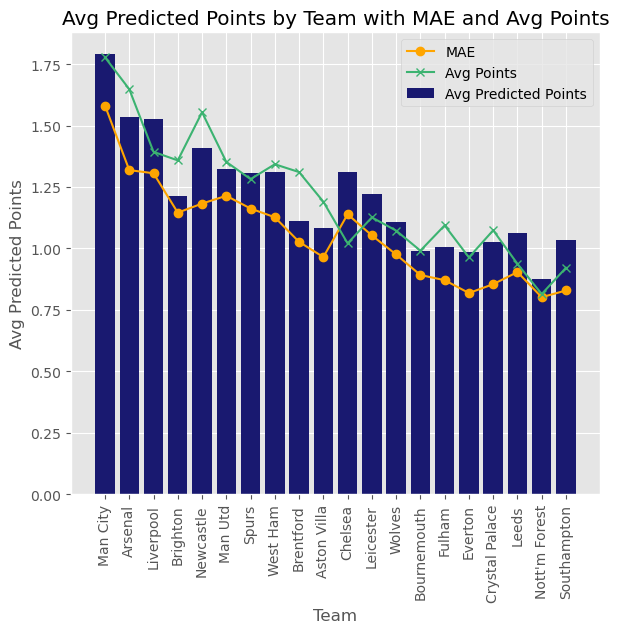

In [197]:
# Sort by mse and select the top 15 players
teams_by_mse = total_team_pred_evals_with_avgs.sort_values(by='mse', ascending=False)

import matplotlib.style as style
style.use('ggplot')

# Plot 1: Avg Predicted Points by Team with MAE and Avg Points
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(teams_by_mse['name'], teams_by_mse['avg_pred'], color='midnightblue')
plt.plot(teams_by_mse['name'], teams_by_mse['mae'], color='orange', marker='o')
plt.plot(teams_by_mse['name'], teams_by_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Team')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Team with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

In [134]:
# Predict on Man City data (highest scoring team)
man_city_pred = rf.predict(df_man_city_x_encoded)

# Calculate Test MSE & MAE
mse_man_city = mean_squared_error(df_man_city_y, man_city_pred)
mae_man_city = mean_absolute_error(df_man_city_y, man_city_pred)

print(f'Man City MSE: %.3f' % mse_man_city)
print(f'Man City MAE: %.3f' % mae_man_city)

Man City MSE: 7.207
Test MAE: 1.581


In [139]:
# Predict on Brighton data (most surprising team)
brighton_pred = rf.predict(df_brighton_x_encoded)

# Calculate Test MSE & MAE
mse_brighton = mean_squared_error(df_brighton_y, brighton_pred)
mae_brighton = mean_absolute_error(df_brighton_y, brighton_pred)

print(f'Brighton MSE: %.3f' % mse_brighton)
print(f'Brighton MAE: %.3f' % mae_brighton)

Brighton MSE: 4.874
Brighton MAE: 1.146


In [143]:
# Look at indexes and predictions for all players in both teams
man_city_player_indexes = {}
brighton_player_indexes = {}
for i in list(df_man_city_x['player_name'].unique()):
    man_city_player_indexes.update({i:df_man_city_x.index[df_man_city_x['player_name'] == i].tolist()})
for i in list(df_brighton_x['player_name'].unique()):
    brighton_player_indexes.update({i:df_brighton_x.index[df_brighton_x['player_name'] == i].tolist()})

In [144]:
# Look at MSE and MAE for top scoring player in league

# Calculate Haaland MSE & MAE
mse_erling_haaland = mean_squared_error(df_man_city_y[man_city_player_indexes['Erling Haaland']], man_city_pred[man_city_player_indexes['Erling Haaland']])
mae_erling_haaland = mean_absolute_error(df_man_city_y[man_city_player_indexes['Erling Haaland']], man_city_pred[man_city_player_indexes['Erling Haaland']])

print(f'Haaland MSE: %.3f' % mse_erling_haaland)
print(f'Haaland MAE: %.3f' % mae_erling_haaland)

Haaland MSE: 33.615
Haaland MAE: 4.350


In [169]:
# Calculate and store MSE and MAE for all players in both teams in dataframes

mse_dict = {}
mae_dict = {}
position = {}
avg_pred = {}
avg_points = {}

for name, indexes in man_city_player_indexes.items():
    mse = mean_squared_error(df_man_city_y[indexes], man_city_pred[indexes])
    mae = mean_absolute_error(df_man_city_y[indexes], man_city_pred[indexes])
    mse_dict.update({name:mse})
    mae_dict.update({name:mae})
    avg_pred.update({name:np.average(man_city_pred[indexes])})
    avg_points.update({name:np.average(df_man_city_y[indexes])})
    position.update({name:df_man_city_x['position'][indexes].unique()[0]})  

for name, indexes in brighton_player_indexes.items():
    mse = mean_squared_error(df_brighton_y[indexes], brighton_pred[indexes])
    mae = mean_absolute_error(df_brighton_y[indexes], brighton_pred[indexes])
    mse_dict.update({name:mse})
    mae_dict.update({name:mae})
    avg_pred.update({name:np.average(brighton_pred[indexes])})
    avg_points.update({name:np.average(df_brighton_y[indexes])})
    position.update({name:df_brighton_x['position'][indexes].unique()[0]})  

# Convert dictionaries to dataframes
df1 = pd.DataFrame(list(mse_dict.items()), columns=['name', 'mse'])
df2 = pd.DataFrame(list(mae_dict.items()), columns=['name', 'mae'])
df3 = pd.DataFrame(list(avg_pred.items()), columns=['name', 'avg_pred'])
df4 = pd.DataFrame(list(avg_points.items()), columns=['name', 'avg_points'])
df5 = pd.DataFrame(list(position.items()), columns=['name', 'position'])

# Merge the two dataframes on the 'name' column
team_pred_evals = pd.merge(df1, df2, on='name')
team_pred_evals_with_avg = pd.merge(team_pred_evals, df3, on='name')
team_pred_evals_with_avgs = pd.merge(team_pred_evals_with_avg, df4, on='name')  
team_pred_evals_with_avgs_and_pos = pd.merge(team_pred_evals_with_avgs, df5, on='name')    

In [170]:
team_pred_evals_with_avgs_and_pos.sort_values(by=['mse'], ascending=False)

,name,mse,mae,avg_pred,avg_points,position
7,Erling Haaland,33.614841,4.350033,5.386617,7.157895,FWD
59,Leandro Trossard,24.366929,3.282548,3.702524,4.611111,MID
16,Kevin De Bruyne,22.000730,3.885066,5.325167,4.815789,MID
24,Phil Foden,17.793606,3.210492,3.476098,3.736842,MID
8,Ilkay Gündogan,16.263498,2.846969,2.993379,3.473684,MID
...,...,...,...,...,...,...
2,Ben Knight,0.009469,0.059859,0.059859,0.000000,MID
4,Claudio Gomes,0.009451,0.059437,0.059437,0.000000,MID
42,Ed Turns,0.004952,0.046433,0.046433,0.000000,DEF
73,Tom McGill,0.002808,0.041086,0.041086,0.000000,GK


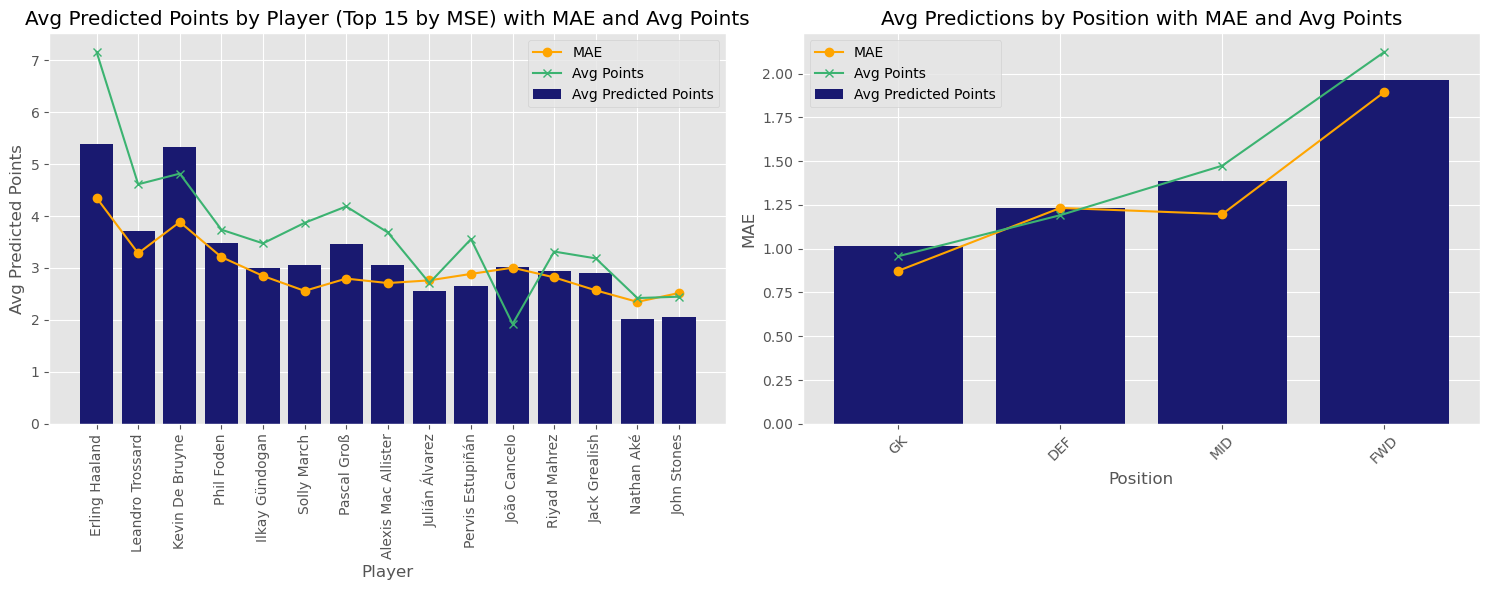

In [183]:
# Sort by mse and select the top 15 players
top_15_mse = team_pred_evals_with_avgs_and_pos.sort_values(by='mse', ascending=False).head(15)

import matplotlib.style as style
style.use('ggplot')

# Plot 1: MAE by player for the top 15 players by MSE
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(top_15_mse['name'], top_15_mse['avg_pred'], color='midnightblue')
plt.plot(top_15_mse['name'], top_15_mse['mae'], color='orange', marker='o')
plt.plot(top_15_mse['name'], top_15_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Player')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Player (Top 15 by MSE) with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

# Plot 2: MAE by position
plt.subplot(1, 2, 2)
position_grouped = team_pred_evals_with_avgs_and_pos.groupby('position').mean('text')
position_grouped_sorted = position_grouped.sort_values(by='avg_pred')
plt.bar(position_grouped_sorted.index, position_grouped_sorted['avg_pred'], color='midnightblue')
plt.plot(position_grouped_sorted.index, position_grouped_sorted['mae'], color='orange', marker='o')
plt.plot(position_grouped_sorted.index, position_grouped_sorted['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Position')
plt.ylabel('MAE')
plt.title('Avg Predictions by Position with MAE and Avg Points')
plt.xticks(rotation=45)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

plt.tight_layout()
plt.show()

# Making a Baseline

In [11]:
# Setting up necessary functions

# Making a vector of predictions as long as the actuals
def pred_vect(true_values, prediction=2):
    predictions = []
    count = 0
    pred = prediction # Can pass baseline or 2
    while count < len(true_values):
        predictions.append(pred)
        count += 1
        
    return predictions

In [12]:
# Creating a baseline with the average value of total points in training set
baseline = Y_train['total_points'].mean()
baseline

1.3593784070590629

In [16]:
true = np.array(Y_train['total_points'])
pred = np.array(pred_vect(Y_train['total_points'],1))

#print(f'RMSE is {round(RMSE(true, pred),3)}')
print(f'MSE is {round(mean_squared_error(true, pred),3)}')
print(f'MAE is {round(mean_absolute_error(true, pred),3)}')

MSE is 6.432
MAE is 1.508
